## K-Means++ 

### Handle latitude/longitude in predictions 


In [1]:
from nextbike.io import input, output
from nextbike.model.utils import prepare_data
from nextbike.model.clustering import cluster
from nextbike.model.classification import logistic_regression
from nextbike.model.regression import polynomial_regression, linear_regression, support_vector_regression
from nextbike.model.ensemble import random_forest


from nextbike.model.classification.logistic_regression import dic
from nextbike.model.ensemble.random_forest import dic
from nextbike.model.regression.polynomial_regression import dic
from nextbike.model.regression.support_vector_regression import dic
from nextbike.model.regression.parameters import model_dic


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


from sklearn.cluster import KMeans

In [2]:
# read in the trip data 
df_final = input.read_csv(loc='processed', name = "dortmund_trips.csv", index_col=0)

In [ ]:
# scatterplot for starting positions of trips 
sns.scatterplot(x="latitude_start", y = "longitude_start", data=df_final)
plt.title("Starting position - Scatterplot")
plt.show()

In [ ]:
cluster_value = cluster.elbow_method(df_final)

In [ ]:
cluster_value["X_scaled"]

In [ ]:
# due to the elbow method number of clusters are set to 4 
km = KMeans(n_clusters = 4)
km.fit(cluster_value["X_scaled"])
df_final["area_start"] = km.predict(cluster_value['X_scaled'])+1

sns.scatterplot(x="latitude_start", y="longitude_start", data=df_final, hue="area_start", palette="cool")
plt.title("Start positions clusterd to areas")
plt.show()

We get the start positions of the trips summed up to four different areas in the city (North-West, South-West, City-Center and North-East). 
This feature could be very useful for the predictions in task 3. 

In [ ]:
output.write_trip_data(df_final)

## Task 3a

### Task 3.1 Linear Models

In [ ]:
df_final.describe()[["trip_duration"]]

In [ ]:
# which features correlate with trip_duration?
df_final.corr()[["trip_duration"]]

In [ ]:
plt.figure(figsize=(15,12))
sns.heatmap(df_final.corr(),cmap="Reds")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.savefig("../doc/figures/CorrelationMatrix.png")
plt.show()

In [ ]:
init = linear_regression.__init__(df_final)

#### Linear Regression

In [ ]:
linear_regression.train(model = 'Linear', init=init)

#### Lasso Regression

In [ ]:
linear_regression.train(model = 'Lasso', init=init)

#### Ridge Regression 

In [ ]:
linear_regression.train(model="Ridge", init=init)

#### Compare results Linear / Lasso / Ridge

In [ ]:
linear_regression.compare_regression_models(init)

### Grid Search
#### Parameter Tuning for Ridge and Lasso Regression 

In [ ]:
df_results = linear_regression.calculate_hyper_parameters(init)

### Ridge with calculated values

In [ ]:
linear_regression.model(model= "Ridge", alpha=4, max_iter=500, random_sate=0, fit_intercept=True, init= init)

### Lasso with calculated values

In [ ]:
linear_regression.model(model= "Lasso", alpha=0.001, max_iter=100, random_sate=0, fit_intercept=True, init= init)

### Task 3.2 Polynominal Regression

In [ ]:
from sklearn.linear_model import Lasso,Ridge, LinearRegression

In [ ]:
init = polynomial_regression.__init__(df_final)

In [ ]:
polynomial_regression.polynomial_reg(model_name= "LinearRegression", estimator = LinearRegression(), degree= 3, init= init)

In [ ]:
polynomial_regression.polynomial_reg(model_name= "LinearRegression", estimator = LinearRegression(), degree= 4, init= init)

In [ ]:
polynomial_regression.polynomial_reg(model_name= "Ridge", estimator= Ridge(), degree=3, init=init)

In [ ]:
polynomial_regression.polynomial_reg(model_name= "Ridge",estimator=ator= Ridge(), degree=4, init= init)

In [ ]:
# hyperparameters found with RandomizedSearch  --> see Task 3.5
polynomial_regression.polynomial_reg("Ridge", Ridge(solver="cholesky", max_iter=40, fit_intercept=True, copy_X=False, alpha=50), degree=4)

In [ ]:
polynomial_regression.polynomial_reg("Lasso", Lasso(), 4)

In [ ]:
polynomial_regression.polynomial_reg("Lasso",Lasso(max_iter=40,fit_intercept=True, copy_X=False, alpha=50), 4)

In [ ]:
pd.set_option('display.max_colwidth', -1)

df_result = pd.DataFrame(polynomial_regression.dic)
df_result

### Task 3.3 Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
init = random_forest.__init__(df_final)

In [ ]:
random_forest.rfr(init, RandomForestRegressor())

--> Model is overfitted, due to the much better metrics for training data than for the test data 

In [ ]:
# set hyperparamters that decrease the complexity of the random forrest
# avoid overfitting - reduce complexity of the model 
random_forest.rfr(init, RandomForestRegressor(n_estimators=50, max_depth=12, min_samples_split=2, min_samples_leaf=15))

In [ ]:
random_forest.rfr(init, RandomForestRegressor(max_features="auto",n_estimators=1155, max_depth=70, min_samples_split=10, min_samples_leaf=8,bootstrap=True))

#### Using log of trip duration 

In [ ]:
init = random_forest.__init__(df_final, log=True)

In [ ]:
rfr = random_forest.rfr(init, RandomForestRegressor())

In [ ]:
rfr = random_forest.rfr(init, RandomForestRegressor(max_features="auto",n_estimators=1155, max_depth=70, min_samples_split=10, min_samples_leaf=8,bootstrap=True))

In [ ]:
# exp the predictions to get correct values 
# compare this with actual values 
random_forest.convert_log_to_exp(init, rfr)

In [ ]:
f, axs = plt.subplots(1,1,figsize=(15,15))
plt.scatter(init['y_test'],rfr['pred'])
plt.ylabel("Predictions",fontsize=18)
plt.xlabel("Actual durations", fontsize=18)
plt.title("Predicted trip durations \n Random Forrest and log of duration used", fontsize=20)
plt.show()

In [ ]:
# summary of results 
df_results = pd.DataFrame(random_forest.dic)
df_results

### Task 3.4 Support Vector Regressor

In [7]:
from sklearn.svm import SVR

In [3]:
init = support_vector_regression.__init__(df_final)

In [4]:
df_final = df_final.sample(50000)

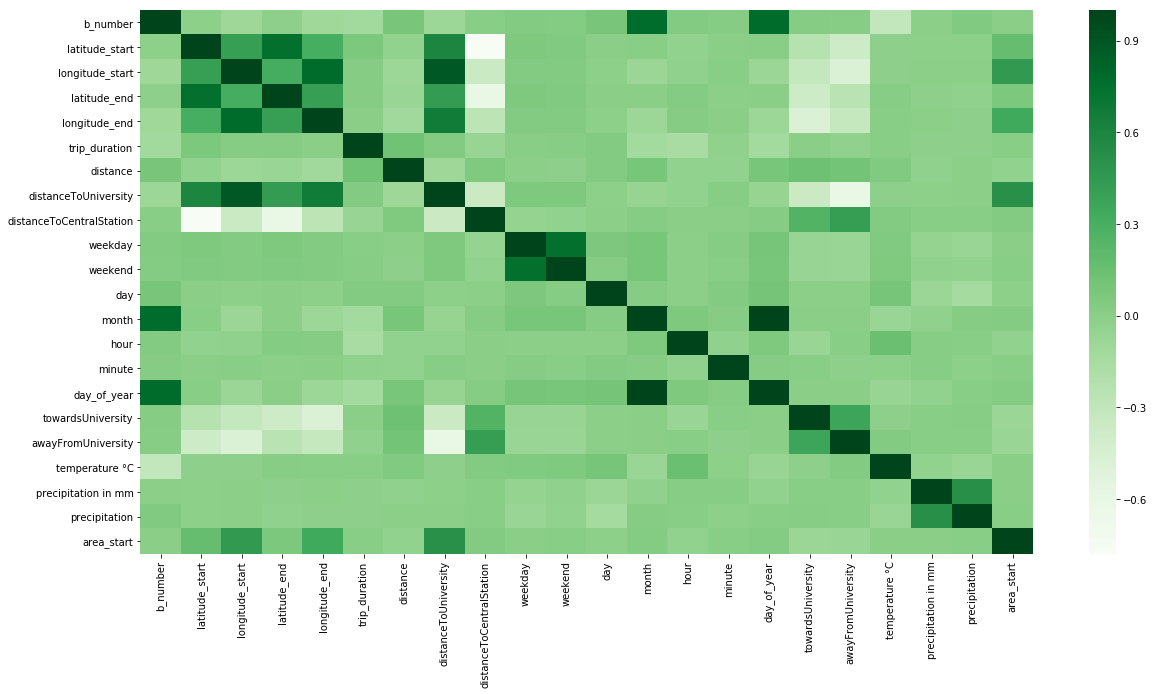

In [6]:
plt.figure(figsize=(20,10))
sns.heatmap(df_final.corr(),cmap="Greens")

In [ ]:
support_vector_regression.train(init=init, estimator=SVR())

In [ ]:
support_vector_regression.train(init=init, estimator= SVR(epsilon=30,C=100,kernel="rbf",gamma="auto"))

### Parameter Tuning 

In [ ]:
support_vector_regression.calculate_hyper_parameter(init)

In [ ]:
support_vector_regression.train(init=init, estimator=SVR(kernel="poly",C=40,epsilon=30,degree=1, gamma="auto", verbose=True,max_iter=500))

In [ ]:
pd.set_option("display.max_colwidth",-1)
df_results = pd.DataFrame(support_vector_regression.dic)
df_results

### Task 3.5 Polynomial Regression - RandomizedSearch

In [ ]:
init = polynomial_regression.__init__(df_final)

In [ ]:
polynomial_regression.calculate_hyper_parameters(init)

## Task 3b

In [3]:
from sklearn import linear_model

In [4]:
init = logistic_regression.__init__(df_final)

## LogisticRegression

### Binary Logistic Regression

In [5]:
# Binary Logistic Regression (awayFromUniversity) 
logistic_regression.explore(model='Binary', typ='away', df = df_final, mod=linear_model.LogisticRegression(), init= init)

              precision    recall  f1-score   support

           0       0.91      1.00      0.96     56903
           1       0.00      0.00      0.00      5340

    accuracy                           0.91     62243
   macro avg       0.46      0.50      0.48     62243
weighted avg       0.84      0.91      0.87     62243



In [6]:
# Binary Logistic Regression (towardsFromUniversity) 
logistic_regression.explore(model='Binary', typ='towards', df = df_final, mod=linear_model.LogisticRegression(), init= init)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     57135
           1       0.00      0.00      0.00      5108

    accuracy                           0.92     62243
   macro avg       0.46      0.50      0.48     62243
weighted avg       0.84      0.92      0.88     62243



### Multilinear Logistic Regression

In [7]:
# Binary Logistic Regression (towardsFromUniversity) 
logistic_regression.explore(model='Multilinear', df = df_final, mod=linear_model.LogisticRegression(), init= init)

                    precision    recall  f1-score   support

awayFromUniversity       0.63      0.87      0.73      3110
  noUniversityRide       0.96      0.98      0.97     53995
 towardsUniversity       0.47      0.22      0.30      5138

          accuracy                           0.91     62243
         macro avg       0.69      0.69      0.67     62243
      weighted avg       0.90      0.91      0.90     62243



## Optimize the Hyperparameters for (binary) LogisticRegression

### These are the best parameters for logistic regression for the attribute awayFromUniversity

In [ ]:
logistic_regression.optimize_hyperparameters(X,y_away)

### These are the best parameters for logistic regression for the attribute towardsUniversity

In [ ]:
logistic_regression.optimize_hyperparameters(X,y_away)

### Performance of the models (with calculated hyperparamters)

In [8]:
# Binary Logistic Regression (awayFromUniversity) 
logistic_regression.train(typ="away", df = df_final, init=init)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     57019
           1       0.00      0.00      0.00      5224

    accuracy                           0.92     62243
   macro avg       0.46      0.50      0.48     62243
weighted avg       0.84      0.92      0.88     62243



In [9]:
# Binary Logistic Regression (towardsUniversity) 
logistic_regression.train(typ="towards", df = df_final, init=init)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     57144
           1       0.00      0.00      0.00      5099

    accuracy                           0.92     62243
   macro avg       0.46      0.50      0.48     62243
weighted avg       0.84      0.92      0.88     62243



In [10]:
df_result = pd.DataFrame(logistic_regression.dic)
df_result

,algorithm,precision,recall,f1score,support,exetime,desc
0,Binary Logistic Regression,0.835775,0.914207,0.873233,None,0.187791,Predicts awayFromUniversity (is complementary ...
1,Binary Logistic Regression,0.842604,0.917935,0.878658,None,0.190612,Predicts awayFromUniversity (is complementary ...
2,Multinomial Logistic Regression,0.899293,0.914641,0.902217,None,6.884966,Predicts tripLabel
3,Binary Logistic Regression,0.839186,0.916071,0.875944,None,0.107771,Optimized hyper-parameters of model in index 0
4,Binary Logistic Regression,0.842869,0.918079,0.878868,None,0.123471,Optimized hyperparameters of model in index 1


## SVM